# Formalia:

Please read the [assignment overview page](https://github.com/lalessan/comsocsci2022/wiki/Assignments) carefully before proceeding. This page contains information about formatting (including formats etc), group sizes, and many other aspects of handing in the assignment. 

_If you fail to follow these simple instructions, it will negatively impact your grade!_

**Due date and time**: The assignment is due on Tuesday, April 5th at 23:55. Hand in your Jupyter notebook file (with extension `.ipynb`) via DTU Learn _(Course Content, Assignemnts, Assignment 2)_


Remember to include in the first cell of your notebook:
* the link to your group's Git repository

https://github.com/LaugeHermansen/Com-soc-assignment-2

* group members' contributions


### Contribution
Everyone has worked equally on each exercise which have contributed to this assignment and the assignment itself. Even tho one may have uploaded more to the github, the uploads where done in unison.


## Part 1: TF-IDF

For this exercise, you need the following data: 
* The r/wallstreetbets submissions (either the one provided by me [here](https://github.com/lalessan/comsocsci2021/blob/master/data/wallstreet_subs.csv.gz) or the one you downloaded in Week 6).
* The list of 15 stocks you identified in Week 6, Exercise 2.


In [2]:
import re
from nltk.book import *
import nltk
import numpy as np
from nltk.corpus import stopwords
from tqdm import tqdm
import pandas as pd
import os
from collections import defaultdict
# from wordcloud import WordCloud
from matplotlib import pyplot as plt

In [3]:
"""
This cell can be ignored

This class just an extension of the porter stemmer
to make the word clouds look nicer
it adds a function called reverse stem, that can turn a stemmed word
back into a real word (not necessarily the word it was before, but a real
word that has a meaning)
"""
class MyStemmer(nltk.PorterStemmer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.reverse_dict = {}
    
    def stem(self, *args, **kwargs):
        stemmed_word = super().stem(*args, **kwargs)
        if stemmed_word not in self.reverse_dict or len(self.reverse_dict[stemmed_word]) > len(args[0]):
            self.reverse_dict[stemmed_word] = args[0]
        return stemmed_word
    
    def reverse_stem(self,stemmed_word):
        if stemmed_word in self.reverse_dict: return self.reverse_dict[stemmed_word]
        else:
            print(f'Warning: {stemmed_word} has not been stemmed.')
            return stemmed_word

try: 
    porter_stemmer = MyStemmer()
    porter_stemmer.reverse_dict = pd.read_pickle('data/reverse_dict.pkl')
except:
    pass

In [5]:
data = pd.read_csv('data/wallstreet_subs.csv.gz')
top15stocks = {'SPY': 1150, 'TSLA': 988, 'SPCE': 562, 'PLTR': 394, 'MSFT': 377, 'ROPE': 359, 'AAPL': 243, 'AMZN': 230, 'NIO': 228, 'ZM': 227, 'AMD': 212, 'BABA': 207, 'GME': 202, 'DIS': 169, 'BA': 164}
porter_stemmer = MyStemmer()
chosen_stocks = ['TSLA', 'MSFT', 'AAPL', 'AMD', 'DIS']


In [6]:
data['text'] = data.title + " " + data.selftext
top15stocks_set = set(top15stocks)


_Exercise_


> 1. Tokenize the __text__ of each submission. Create a column __tokens__ in your dataframe containing the tokens. Remember to follow the instructions in Week 6, Exercise 3.

In [77]:
stemmed_stopwords = set(map(porter_stemmer.stem, stopwords.words('english')))

def tokenize_stem_remove(text):

    def tokenize_stem_remove_gen(text):
        for word in map(porter_stemmer.stem, nltk.tokenize.word_tokenize(text.lower())):
            if   re.search(r'http|www.|.com', word): pass
            elif re.search(r'\d', word):             pass
            elif re.search(r'\W', word):             pass
            elif word in stemmed_stopwords:          pass
            elif word[0] == '$' and len(word) > 1:   yield word[1:]
            elif len(word) != 0:                     yield word
    
    return list(tokenize_stem_remove_gen(text))

In [78]:
#TODO remove the input if statement but keep the line
# Til Christian og Karl: Den her celle tager lidt tid
#    - derfor der lige er et ekstra tjek på, om i virkelig vil køre den
# bare tryk 'y'
if input('really?!? (y/n)') == "y":
    data['tokens_not_unique'] = [tokenize_stem_remove(text) for text in tqdm(data['text'])]
else:
    print('no')

100%|██████████| 82242/82242 [05:17<00:00, 258.87it/s]


In [79]:
data['tokens'] = [set(tokens) for tokens in data['tokens_not_unique']]

In [9]:
mentioned_stocks = [[].copy() for i in range(len(data))]

for i in range(len(data)):
    words = re.findall(r'\$[a-zA-Z]+', data.text[i])
    for w in words:
        mentioned_stocks[i].append(w[1:].upper())
    mentioned_stocks[i] = set(mentioned_stocks[i])

data['mentioned_stocks'] = mentioned_stocks

In [10]:
all_stocks_set = set(stock for stocks in mentioned_stocks for stock in stocks)

In [12]:
#TODO this cell should be commented out
# Til Christian og Karl: Jeg anbefaler at i gemmer første gang i kører, og loader resten

"""
This cell has been used for testing purposes - so we didn't have to run it all
every time we started, but could just save and load the pandas dataframe
"""
try:
    answer = int(input('(load/save) data: (0/1)'))
    if answer == 0:
        data = pd.read_pickle('data/data.pkl')
        porter_stemmer = MyStemmer()
        porter_stemmer.reverse_dict = pd.read_pickle('data/reverse_dict.pkl')
        print('data read successfully')
    elif answer == 1:
        pd.to_pickle(data, 'data/data.pkl')
        pd.to_pickle(porter_stemmer.reverse_dict, 'data/reverse_dict.pkl')
        print('data saved successfully')
except ValueError:
    print('Invalid answer')
except FileNotFoundError:
    print('No such file in directory')

data saved successfully


  
> 2. Find submissions discussing at least one of the top 15 stocks you identified above (follow the instructions in Week 6, Exercise 3).
> 3. Now, we want to find out which words are important for each *stock*, so we're going to create several ***large documents, one for each stock***. Each document includes all the tokens related to the same stock. We will also have a document including discussions that do not relate to the top 15 stocks.


In [13]:
documents = defaultdict(lambda: defaultdict(lambda: 0))
stemmed_stocks = {stock: porter_stemmer.stem(stock) for stock in top15stocks_set}

for mentioned_stocks, text in tqdm(zip(data.mentioned_stocks, data.tokens)):
    for word in text:
        stocks = mentioned_stocks & top15stocks_set
        for stock in stocks:
            if stemmed_stocks[stock] != word:
                documents[stock][word] += 1
        if len(stocks) == 0:
            documents['Other'][word] += 1
        


82242it [00:03, 25166.94it/s]


In [14]:
document_sizes = {stock: sum(words.values()) for stock, words in documents.items()}

> 4. Now, we're ready to calculate the TF for each word. Find the top 5 terms within __5 stocks of your choice__. 


In [15]:
def get_top_n(n, dictionary, decreasing = True):
    keys, values = map(np.array, zip(*dictionary.items()))
    if decreasing:
        return keys[np.argsort(values)[:-n-1:-1]], np.sort(values)[:-n-1:-1]
    else:
        return keys[np.argsort(values)[:n]], np.sort(values)[:n]

def print_top_n(chosen_stocks, n, dictionaries, decreasing = True, include_value = False):
    topn = {}
    for stock in chosen_stocks:
        if include_value:
            topn[stock] = [f'{porter_stemmer.reverse_stem(key)}:  {value:.3%}' for key, value in zip(*get_top_n(n, dictionaries[stock], decreasing))]
        else:
            topn[stock] = [f'{porter_stemmer.reverse_stem(key)}' for key in get_top_n(n, dictionaries[stock], decreasing)[0]]

    print(pd.DataFrame(topn))
    

In [16]:
tf = {}
for stock, words in documents.items():
    count = np.array(list(words.values()))
    words = np.array(list(words.keys()))
    mask = np.argsort(-count)
    tf[stock] = {word:c for word,c in zip(words[mask], count[mask]/document_sizes[stock])}

In [17]:
print_top_n(chosen_stocks, 5, tf, decreasing=True, include_value=True)

             TSLA           MSFT           AAPL            AMD            DIS
0   call:  0.650%  call:  0.779%  call:  0.522%  call:  0.669%   put:  0.604%
1     go:  0.633%    go:  0.574%    go:  0.495%    go:  0.569%    go:  0.594%
2    buy:  0.516%   buy:  0.561%  like:  0.482%   buy:  0.489%   buy:  0.524%
3  stock:  0.484%   get:  0.474%   buy:  0.448%  like:  0.459%   get:  0.514%
4   like:  0.479%  fuck:  0.443%   get:  0.441%   day:  0.449%  call:  0.474%


>   * Describe similarities and differences between the stocks.
>       * The stocks seem to share many of the top 5 words such as 'call', 'go', 'get' and 'buy'. There are few variations, but the top 5 words don't seem to say much about the stock.
 
 

>> Note that all the stocks have their own name as the term with highest frequency, but that seems very obvious that those are mentioned often when talking about themselves, so that has been removed to make space for more interesting words. However, the occurences of stocks have not been removed from the documents of the other stocks - e.g. AAPL has not been removed from MSFT - only from itself.
>   * Why aren't the TFs necessarily a good description of the stocks?
>       * Because the words that have a high tf in each of the stock, are usually just common words - words that are used a lot, and not restricted to the specific stock. Also, we can see that in the fact that all the stocks have the same words in their top 5 - almost, at least. 
>       * It is more interesting to find the tf-idf as this takes the overall frequency of the terms into account, i.e. the number of documents they appear in.
>   * Next, we calculate IDF for every word. 


In [18]:
idf = defaultdict(lambda: 0)
for stock, words in documents.items():
    for word in words:
        idf[word] += 1

for word in idf:
    idf[word] = np.log(len(documents)/idf[word])

>   * What base logarithm did you use? Is that important?
>     * Numpy uses the natural $\log$ i.e. with base $e$. However, the base is not important for idf, because $$\log_a(b)\cdot \log_b(c) = \log_a(c).$$ This means that $\log_a(x) \propto \log_b(x)$, and therefore the base will change the actual idf score. However, it will just scale by a constant, so proportionally it won't make any difference.
> 5. We're ready to calculate TF-IDF. Do that for the __5 stock of your choice__. 


In [19]:
tf_idf = {}
for stock in chosen_stocks:
    tf_idf[stock] = {word: tf[stock][word]*idf[word] for word in tf[stock]}

>   * List the 10 top TF words for each stock.


In [20]:
print_top_n(chosen_stocks, 10, tf, decreasing=True, include_value=False)

    TSLA    MSFT    AAPL     AMD     DIS
0   call    call    call    call     put
1     go      go      go      go      go
2    buy     buy    like     buy     buy
3  stock     get     buy    like     get
4   like    fuck     get     day    call
5    get    time   stock  market    like
6   make   stock    appl   stock  disney
7   time  market    time    make  market
8  tesla    like  market     put    week
9    amp     amp    week    fuck    fuck


>  * List the 10 top TF-IDF words for each stock.


In [21]:
print_top_n(chosen_stocks, 10, tf_idf)

         TSLA       MSFT         AAPL       AMD          DIS
0        musk      satya          tim       cpu        mouse
1          vw       jedi           io       gpu       disney
2   inclusive      nunya          lvl       apu         park
3       tesla    nadella          plz      lisa   disneyland
4   panasonic       gate      decimal    nvidia       mickey
5        spce      award           ty  firework        tokyo
6         lvl    martial       daoism       yea      orlando
7         plz  macrohard  autsitcally      grim  mandalorian
8  cybertruck  falsehood       geting      flop        mulan
9        catl       spce         epic     macro         siri


>   * Are these 10 words more descriptive of the stock? If yes, what is it about IDF that makes the words more informative?
>      * Yes the words with high tf-idf scores are much more descriptive of the stocks. This because, the idf is an inverse measure of how normal a word is, where the tf is a measrue of how normal a word is in a given document. This means that if a word occurs in many documents, it will downweight the tf-idf score. Therefore in order for a word to have a high tf-idf score, it must occur many times in the document, and only occur in few documents. Hence, the high tf-idf score words intuitively describe the stocks pretty well.


> 6. Visualize the results in a Wordcloud and comment your results (follow the instrutions in Week 6, Exercise 4). 


In [ ]:
def plot_word_cloud(chosen_stocks, size_dict, ncols, title):
    unstemmed_size_dict = {stock: {porter_stemmer.reverse_stem(key): value for key,value in size_dict[stock].items()} for stock in size_dict}
    word_clouds = [WordCloud(height = 400, background_color='white').generate_from_frequencies(unstemmed_size_dict[stock]) for stock in chosen_stocks]
    nrows = int(np.ceil(5/ncols))
    fig, axs = plt.subplots(nrows,ncols,figsize = (10*ncols,10*nrows))
    for _,ax in np.ndenumerate(axs): ax.axis('off')
    for wc, ax, stock in zip(word_clouds, np.reshape(axs,nrows*ncols), chosen_stocks):
        ax.imshow(wc)
        ax.set_title(stock, fontsize = 70)
    fig.suptitle(title, fontsize = 40)


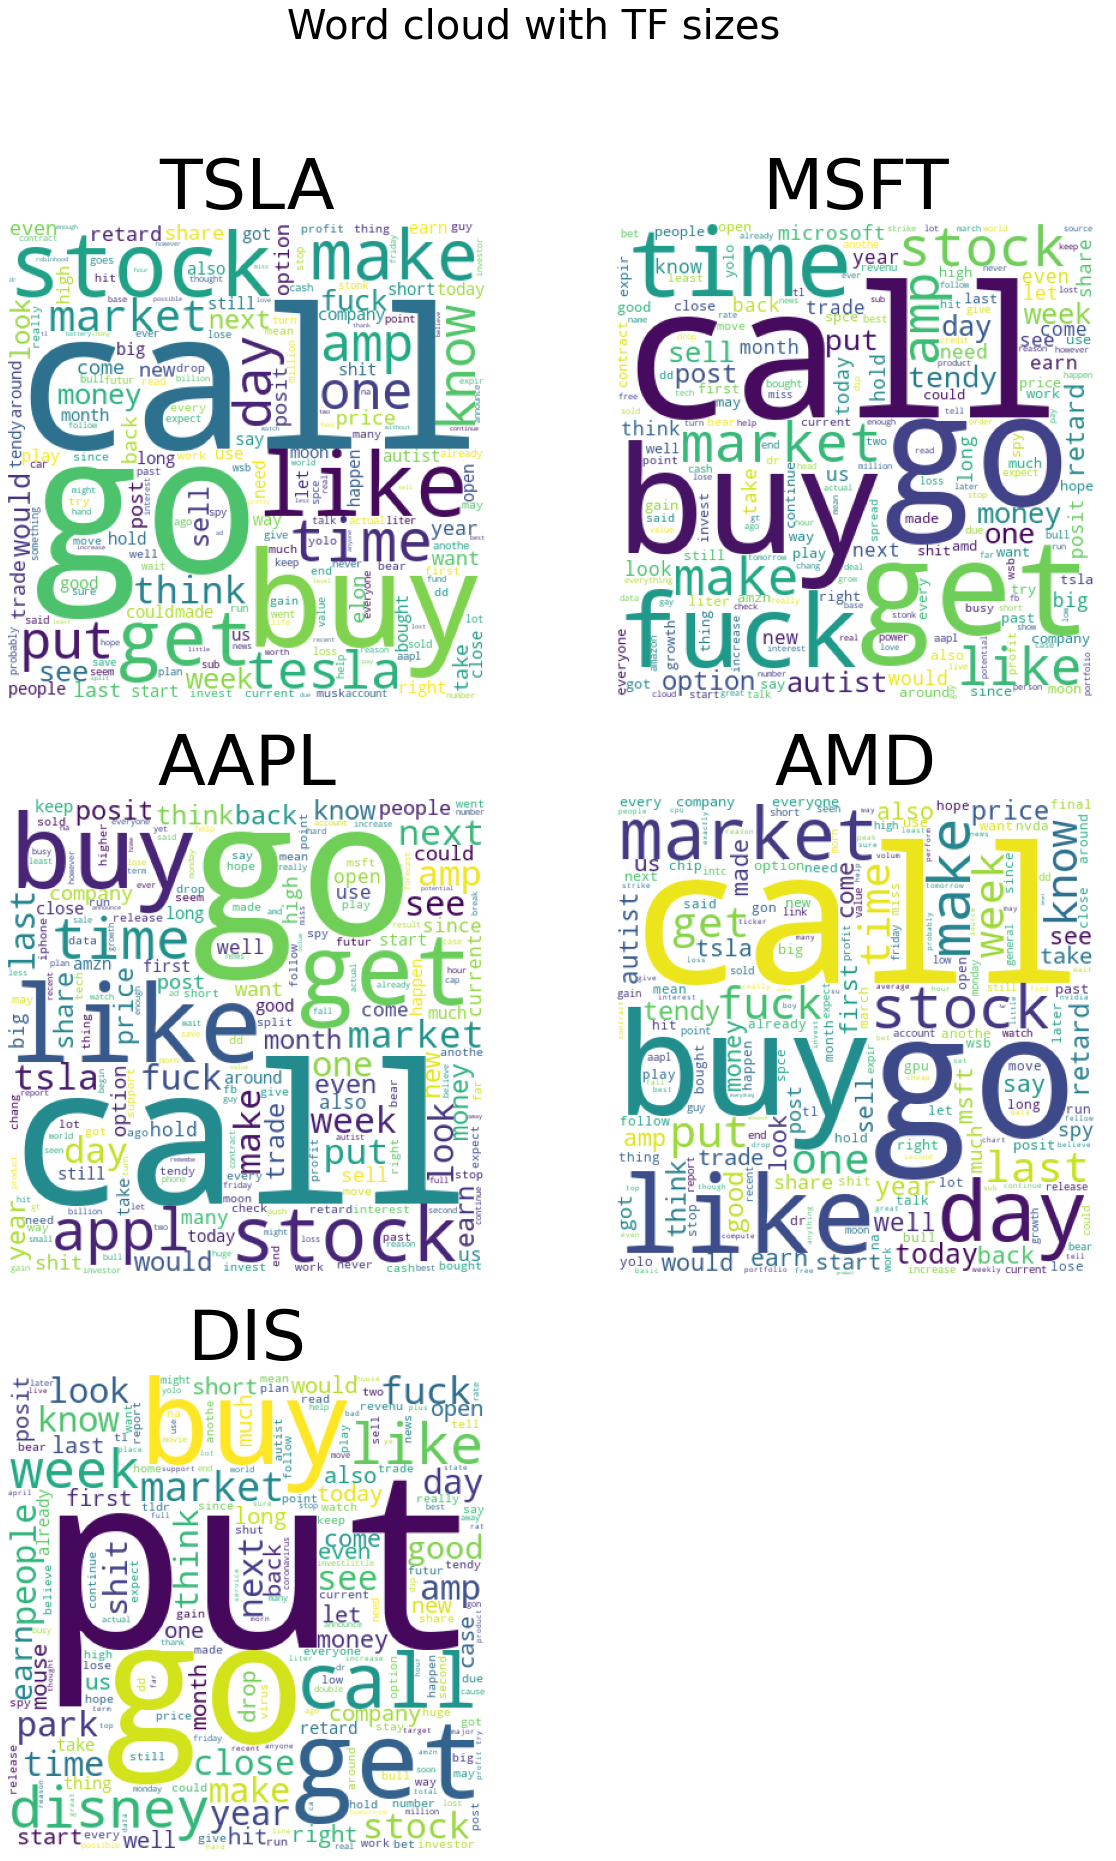

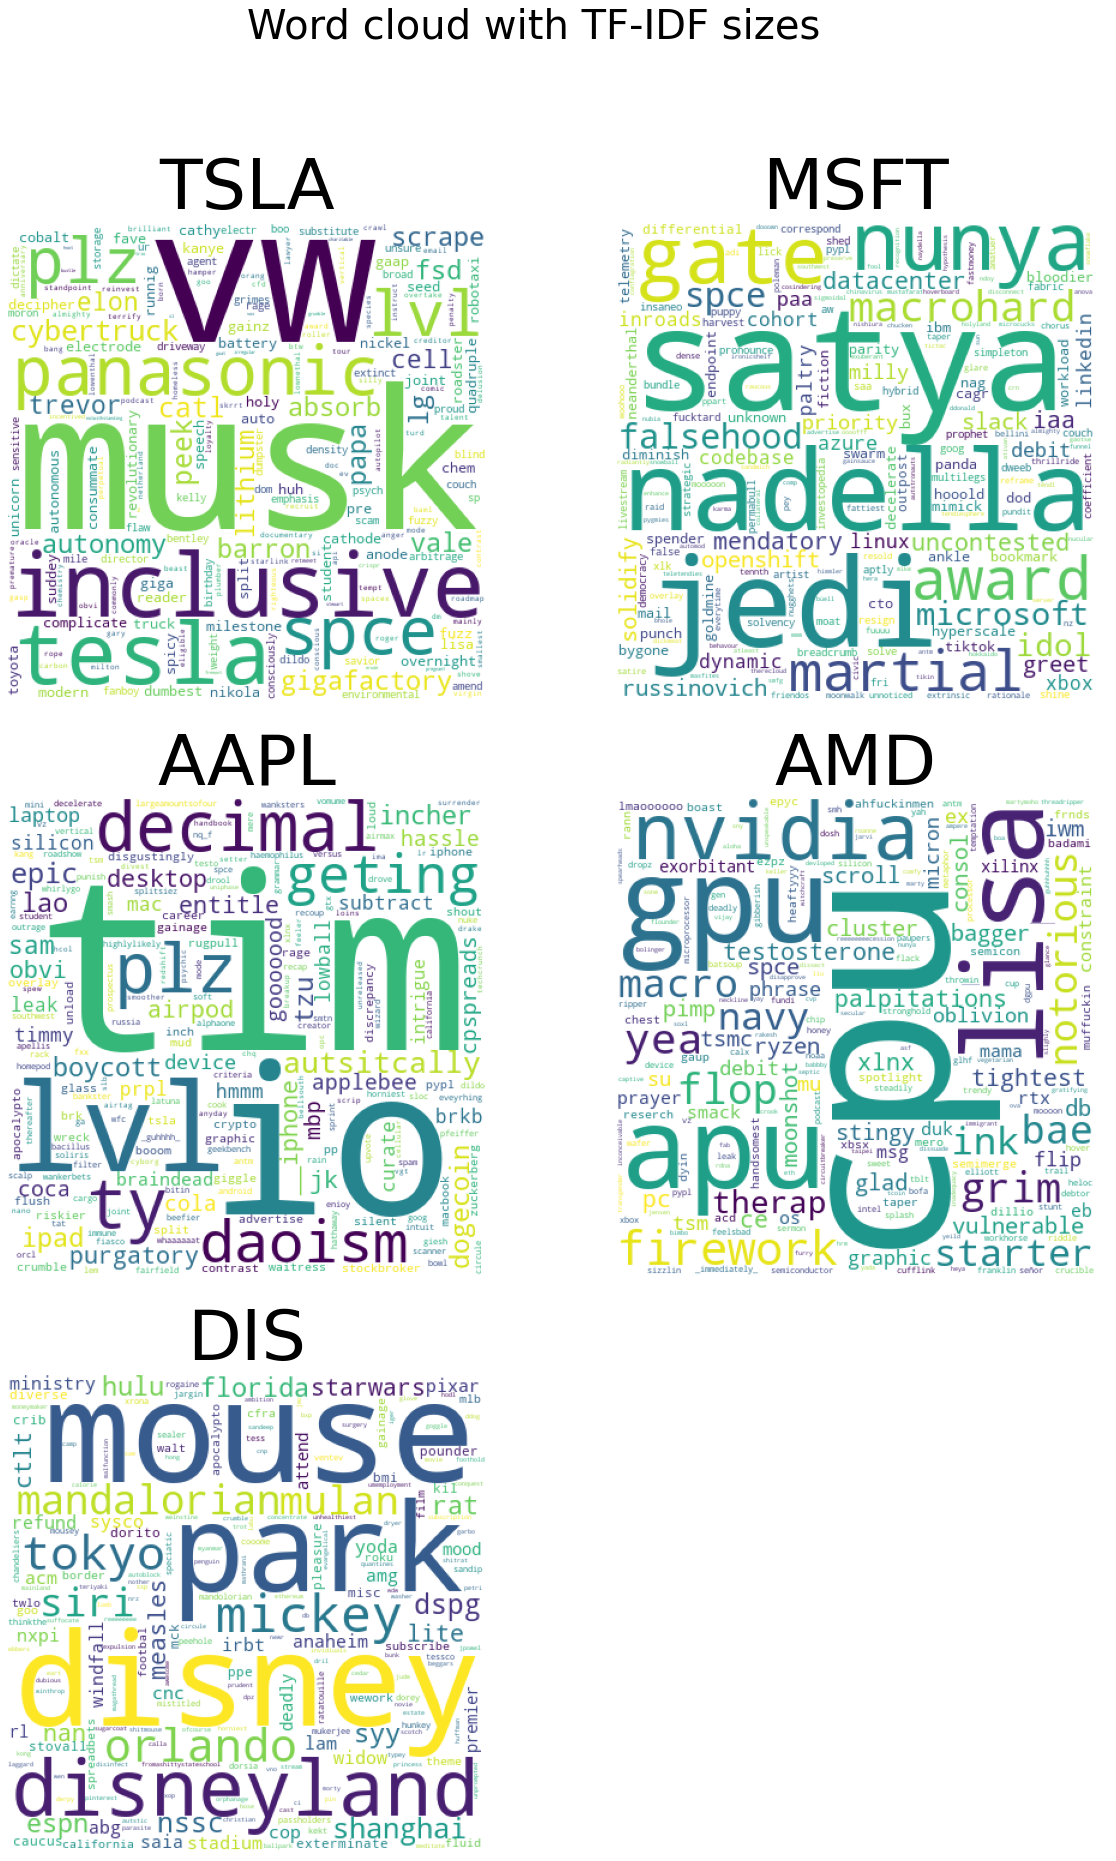

In [ ]:
plot_word_cloud(chosen_stocks, tf,2,'Word cloud with TF sizes')
plot_word_cloud(chosen_stocks, tf_idf,2,'Word cloud with TF-IDF sizes')

First a little introduction to the way we created the word clouds.

>We have calculated the sizes of the words based on how many submissions the stemmed terms appear in, and then "unstemmed" them afterwards. For example, the stem of "mouse" is "mous", so this is what we have calculated the sizes for. But in the word cloud plot, this is plotted as "mouse", because it is a real word, that is easier understood. But the stem of "mice" is also "mous", so the word "mouse" on the plot represents all apperances of both "mouse" and "mice". This way, we avoid the problem of multiple versions of the same word, while still getting a meaningful word cloud plot. The representative is the shortest apperance amongst the ones that has stem "mous" - so in this case it would have been "mice" on the word cloud, but mice is not in the vacabulary. The example still serves the purpose of explanation.

Now the comments on the word cloud.

>Just as earlier, the wordcloud for the frequencies is not that interesting. It is much more interesting to look at the plot where the sizes of the words are scaled with their tf-idf score. Here we see that many of the big words are not surprising at all. E.g. in AMD, words like "cpu", "gpu", "nvidia", "flop" are very common, which aligns great with the fact that AMD produces processors and are usually used for gaming and training neural networks. Also DIS (Disney) makes a lot of sense. Looking at TSLA, they mention Elon Musk, and other companies like panasonic, VW and SPCE (Vergin galactic) are also high on the list. 

> It is interesting to look at MSFT and AAPL. Here there are many words that on't seem descriptive of the companies at all, such as for AAPL, "daoism", "ty", "lvl", "plz" and "decimal" and for MSFT, "gate", "martial" and "jedi". These words seem a bit wierd for companies creating computers. However, there is one thing about them that are no surprises, and they there this with 4 of the 5 stocks. They have their CEO's as one of the most popular words. This makes sense, as the CEO of a company in many cases is also the face of the company - especially in a world where social media plays a huge role. The only company that doesn't have the CEO high on the list. Only Disney don't have their CEO represented in the wordcloud (at least not as a big word), but that makes sense too, as they are a very visible company in many other ways already. When we get entertainment about the other companies, it usually involves gossip about their CEO, but when we get entertainment from Disney we buy their product. Therefore, their products are popular on their word cloud.

## Part 2: Sentiment analysis

_Exercise: Creating Word Shifts_
>    1. Pick a day of your choice in 2020. We call it $d$. It is more interesting if you pick a day where you expect something relevant to occur (e.g. Christmas, New Year, Corona starting, the market crashes...).


Day chosen, 11 March 2020 - day WHO announced pandemic

>    2. Build two lists $l$ and $l_{ref}$ containing all tokens for submissions posted on r/wallstreebets on day $d$, and in the 7 days preceding day $d$, respectively. 


In [185]:
from datetime import datetime

data['date'] = [datetime.utcfromtimestamp(time) for time in data['created_utc']]

day_start, day_end = pd.Timestamp(2020, 3, 11), pd.Timestamp(2020, 3, 11, 23, 59, 59)
day_start, day_end

(Timestamp('2020-03-11 00:00:00'), Timestamp('2020-03-11 23:59:59'))

In [84]:
date_filter = np.array(day_start <= data['date']) & np.array(data['date'] <= day_end)
date_filter_ref = np.array(day_start <= data['date'] - pd.Timedelta('7D') ) &\
                           np.array(data['date']  - pd.Timedelta('7D') <= day_end)

df_day = data[ date_filter ]
df_day_ref = data[ date_filter_ref ]


>    3. For each token $i$, compute the relative frequency in the two lists $l$ and $l_{ref}$. We call them $p(i,l)$ and $p(i,l_{ref})$, respectively. The relative frequency is computed as the number of times a token occurs over the total length of the document. Store the result in a dictionary.


In [85]:
l = sum(df_day['tokens_not_unique'], [])
l_ref = sum(df_day_ref['tokens_not_unique'], [])

In [107]:
p = {token: count / len(l) for token, count in zip(*np.unique(l, return_counts=True))}
p_ref = {token: count / len(l_ref) for token, count in zip(*np.unique(l_ref, return_counts=True))}


>    4. For each token $i$, compute the difference in relative frequency $\delta p(i) = p(i,l) - p(i,l_{ref})$. Store the values in a dictionary. Print the top 10 tokens (those with largest relative frequency). Do you notice anything interesting?


In [108]:
delta = {token: p[token] - p_ref[token] for token in set(p.keys()) & set(p_ref.keys())}

>    5. Now, for each token, compute the happiness $h(i) = labMT(i) - 5$, using the labMT dictionary. Here, we subtract $5$, so that positive tokens will have a positive value and negative tokens will have a negative value. Then, compute the product $\delta \Phi = h(i)\cdot \delta p(i)$. Store the results in a dictionary. 


In [136]:
df_hedo = pd.read_csv('data/Hedonometer.csv')
df_hedo['as_token'] = [ tokenize_stem_remove(word)[0] if tokenize_stem_remove(word) != [] else "" for word in df_hedo['Word']]

# This is the mean tokenised happiness score for words with the same tokens
h = df_hedo[['Happiness Score', "as_token"]][ df_hedo['as_token'] != "" ]\
           .groupby('as_token').mean().sort_values("Happiness Score", ascending=False)
h['Happiness Score'] = [score - 5 for score in h['Happiness Score']]

In [173]:
know_scores = set(h.index)
delta_phi = {token: float(h.loc[token]) * delta[token] for token in delta.keys() if token in know_scores}
abs_delta_phi = {token: abs(delta_phi[token]) for token in delta_phi.keys()}

>    6. Print the top 10 tokens, ordered by the absolute value of $|\delta \Phi|$. Explain in your own words the meaning of $\delta \Phi$. If that is unclear, have a look at [this page](https://shifterator.readthedocs.io/en/latest/cookbook/weighted_avg_shifts.html).


delta_phi is the contribution of possitive change the word gives. If the word have a negative score and decreases in frequency used, the dobble negative cancels and contributes to a possitive change. The magnitude of delta_phi is proportional to the happiness score and frequency of the word


In [176]:
list(zip(*get_top_n(10, abs_delta_phi)))

[('money', 0.005876828184768271),
 ('coronaviru', 0.005760904062251873),
 ('viru', 0.004363354949310041),
 ('shit', 0.0036445824775677704),
 ('cash', 0.00364321983595461),
 ('corona', 0.003120022402255446),
 ('pandem', 0.0029062128010142055),
 ('cancel', 0.002645314913304718),
 ('gold', 0.0025836078868067777),
 ('option', 0.002477942469193678)]

>    7. Now install the [``shifterator``](https://shifterator.readthedocs.io/en/latest/installation.html) Python package. We will use it for plotting Word Shifts. 
>    8. Use the function ``shifterator.WeightedAvgShift`` to plot the WordShift, showing which words contributed the most to make your day of choice _d_ happier or more sad then days in the preceding 7 days. Comment on the figure. 

C:\Users\niels\anaconda3\envs\SocialScience\lib\site-packages\shifterator\plotting.py:604: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, fontsize=plot_params["xtick_fontsize"])


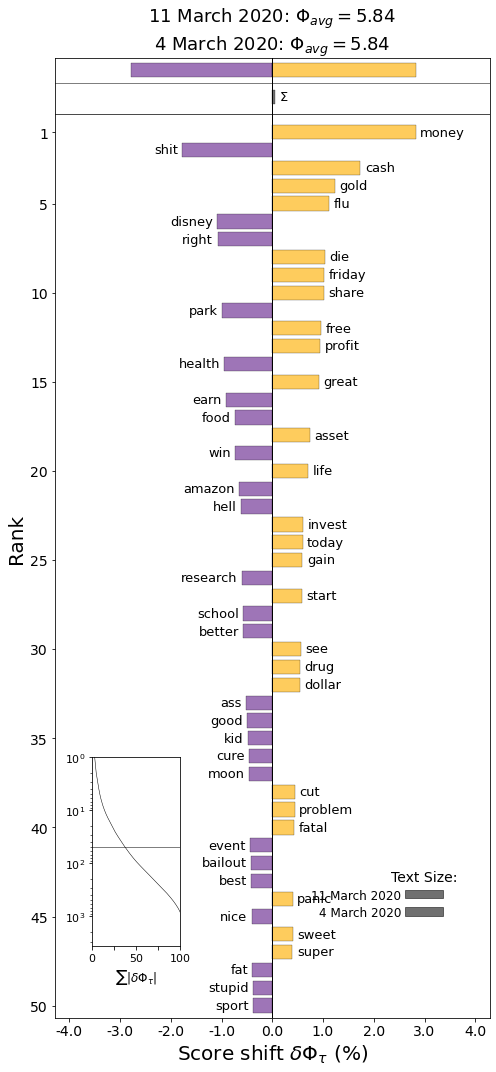

<AxesSubplot:title={'center':'11 March 2020: $\\Phi_{avg}=$5.84\n4 March 2020: $\\Phi_{avg}=$5.84'}, xlabel='Score shift $\\delta \\Phi_{\\tau}$ (%)', ylabel='Rank'>

In [184]:
import shifterator as sh

sentiment_shift = sh.WeightedAvgShift(type2freq_1=p,
                                      type2freq_2=p_ref,
                                      type2score_1='labMT_English',
                                      reference_value=5,
                                      stop_lens=[(4,6)])

sentiment_shift.get_shift_graph(detailed=False,
                                system_names=['11 March 2020', '4 March 2020'])

>    9. How do words that you printed in step 6 relate to those shown by the WordShift? 

Some of the words overlap, and of these words, they appear in the same order.

## Part 3: Communities for the Zachary Karate Club Network

_Exercise: Zachary's karate club_: In this exercise, we will work on Zarachy's karate club graph (refer to the Introduction of Chapter 9). The dataset is available in NetworkX, by calling the function [karate_club_graph](https://networkx.org/documentation/stable/auto_examples/graph/plot_karate_club.html).

> 1. Visualize the graph using [netwulf](https://netwulf.readthedocs.io/en/latest/). Set the color of each node based on the club split (the information is stored as a node attribute). My version of the visualization is below.
>
> 2. Write a function to compute the __modularity__ of a graph partitioning (use **equation 9.12** in the book). The function should take a networkX Graph and a partitioning as inputs and return the modularity.
> 3. Explain in your own words the concept of _modularity_. 
> 4. Compute the modularity of the Karate club split partitioning using the function you just wrote. Note: the Karate club split partitioning is avilable as a [node attribute](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.classes.function.get_node_attributes.html), called _"club"_.
> 5. We will now perform a small randomization experiment to assess if the modularity you just computed is statitically different from $0$. To do so, we will implement a [configuration model](https://en.wikipedia.org/wiki/Configuration_model). In short, we will create a new network, such that each node has the same degree as in the original network, but different connections. Here is how the algorithm works.
>       * __a.__ Create an identical copy of your original network. 
>       * __b.__ Consider the list of network edges. Create two lists: the list of source nodes and target nodes. (e.g. edges = [(1,2),(3,4)], sources = [1,3], targets = [2,4])
>       * __c.__ Concatenate the list of source nodes and target nodes into a unique list (e.g. [1,3,2,4]). This is the list of _stubs_ (see the [Wikipedia page](https://en.wikipedia.org/wiki/Configuration_model) for the definition of stub).
>       * __d.__ Shuffle the list of stubs. Build a set of edges (tuples), by connecting each element in the list of shuffled stubs with the following element. (e.g. [4,1,2,3] --> [(4,1),(2,3)])
>       * __e.__ Remove all the original network edges from your network. Add all the new _shuffled_ edges you created in step __d.__
> 6. Is the degree of the nodes in your original and the configuration model network the same? Why? __Note 1:__ With this algorithm you may obtain some self-loops. Note that [a self-loop should add two to the degree](https://en.wikipedia.org/wiki/Loop_(graph_theory%29#:~:text=For%20an%20undirected%20graph%2C%20the,adds%20two%20to%20the%20degree.&text=In%20other%20words%2C%20a%20vertex,not%20one%2C%20to%20the%20degree.). __Note 2:__ With this algorithm, you could also obtain repeated edges between the same two nodes. Only NetworkX [MultiGraph](https://networkx.org/documentation/stable/reference/classes/multigraph.html) allow for repeated edges, while regular [Graph](https://networkx.org/documentation/stable/reference/classes/graph.html?highlight=graph%20undirected#networkx.Graph) do not, meaning you will not be able to account for multi-edges when you have a regular Graph. (_Optional_: if you want to implement a configuration model without self-loops and multi-edges, you can try out the [double_edge_swap](https://networkx.org/documentation/stable//reference/algorithms/generated/networkx.algorithms.swap.double_edge_swap.html) algorithm)
> 7. Create $1000$ randomized version of the Karate Club network using the algorithm you wrote in step 5. For each of them, compute the modularity of the "club" split and store it in a list.
> 8. Compute the average and standard deviation of the modularity for the configuration model.
> 9. Plot the distribution of the configuration model modularity. Plot the actual modularity of the club split as a vertical line (use [axvline](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axvline.html)). 
> 10. Comment on the figure. Is the club split a good partitioning? Why do you think I asked you to compare with the configuration model? What is the reason why we preserved the nodes degree?
> 11.  Use [the Python Louvain-algorithm implementation](https://anaconda.org/auto/python-louvain) to find communities in this graph. Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the club split? What does this comparison reveal?
> 12.  Compare the communities found by the Louvain algorithm with the club split partitioning by creating a matrix **_D_** with dimension (2 times _A_), where _A_ is the number of communities found by Louvain. We set entry _D_(_i_,_j_) to be the number of nodes that community _i_ has in common with group split _j_. The matrix **_D_** is what we call a [**confusion matrix**](https://en.wikipedia.org/wiki/Confusion_matrix). Use the confusion matrix to explain how well the communities you've detected correspond to the club split partitioning.

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
from netwulf import visualize
import netwulf as wulf
karate_data = nx.karate_club_graph()
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
karate_data.nodes[0]["club"]

karate_data_color = karate_data.copy()
for n in karate_data.nodes(data=False):
    if karate_data.nodes[n]['club'] == 'Mr. Hi':
        karate_data_color.nodes[n]['color'] = 'red'
    else:
        karate_data_color.nodes[n]['color'] = 'blue'

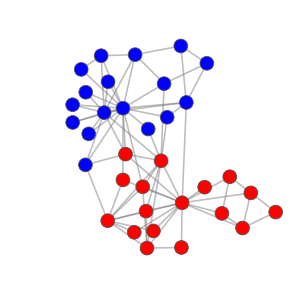

In [ ]:
config_dict = {'zoom':3.5,'display_node_labels': True,}
network, config = wulf.visualize(karate_data_color,config=config_dict,  plot_in_cell_below=False)
fig, ax = wulf.draw_netwulf(network)
plt.show()

For some reason, python refuses to show labels on the data

In [ ]:
def modularity(network, partitioning):
    L = network.number_of_edges()
    out_degs = [network.degree[u] for u in network]
    
    mod = 0
    for partition in partitioning:
        # Lc =  Total number of links in community
        Lc = len([(u, v) for u, v in network.edges(partition) if v in partition])
        kc = sum([out_degs[i] for i in partition])
        mod += Lc/L - (kc/(2*L))**2
    
    return mod
# testing the function to see if it works... it does most likely
graphos_maximos = nx.random_partition_graph([5,5,5,5,5,5,4], 0.1, .01)
modul = modularity(graphos_maximos, nx.random_partition_graph([5,5,5,5,5,5,4], .5, .5).graph['partition'])


{0, 1, 2, 3, 4}
{5, 6, 7, 8, 9}
{10, 11, 12, 13, 14}
{15, 16, 17, 18, 19}
{20, 21, 22, 23, 24}
{25, 26, 27, 28, 29}
{32, 33, 34, 30, 31}


0.41049382716049376

### Explain modularity in your own words

Modularity is a measure of how well a partitioning of nodes in a graph explains those communities. It measures the interconnectivity between the nodes in the given partitions, compared to their connectivity to the rest of the graph; if the modularity of a graph is high, then the given partitioning is mostly likely, a correct explnation of the communities in the graph. If the modularity is close to 0, the connectivity of the partioning is imply explained by the expected out degree of every node in the given partition. If it is negative, the given partitioning is not a community, but there may be others.

In [ ]:
clubs = nx.get_node_attributes(karate_data_color, 'club')
part = [[node for node, cl in clubs.items() if cl == club] for club in ['Mr. Hi', 'Officer']]

karate_modularity = modularity(karate_data_color, part)
print('The modularity of karate is: ', karate_modularity)

The modularity of karate is:  0.3582347140039447


In [ ]:
def create_random(graph, v=False):
    los_copios = karate_data_color.copy()
    list(los_copios.edges)

    sources = [i[0] for i in list(los_copios.edges)]
    targets = [i[1] for i in list(los_copios.edges)]
    concat = sources + targets
    import random
    random.shuffle(concat)
    new_sources = concat[:len(sources)]
    new_targets = concat[len(sources):]
    assert len(new_sources) == len(new_targets)

    new_edges = [(u, v) for u, v in zip(new_sources, new_targets)]
    los_copios = nx.create_empty_copy(los_copios)
    los_copios.update(edges=new_edges)
    if v:
        # Checking if edges is the same
        changed = len([n for n in los_copios.nodes if los_copios.degree[n] != karate_data_color.degree[n]])
        total_deg_diff = sum([karate_data_color.degree[n] for n in karate_data_color.nodes]) - sum([los_copios.degree[n] for n in los_copios.nodes])
        print(f"{changed} nodes changed degree, total degree loss: {total_deg_diff}")
    
    return los_copios   

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2968.37it/s]


Average modularity is:  0.0001141387680341425


In [ ]:
# Get average modularity over 1000 random graphs    
rands = [create_random(karate_data_color) for i in tqdm(range(1000))]
moduls = [modularity(G, part) for G in rands]

mean_modul = sum(moduls)/len(moduls)
sd_modul = 1/(len(moduls)-1) * math.sqrt(sum([(i - mean_modul)**2 for i in moduls]))

print('Average modularity is: ', mean_modul)
print('Modularity SD is: ', sd_modul)

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2828.58it/s]


Average modularity is:  -0.001444579046372087
Modularity SD is:  0.0016774428080107188


### Comment on the figure. Is the club split a good partitioning? Why do you think I asked you to compare with the configuration model? What is the reason why we preserved the nodes degree?

The split of the clubs seems to be a good partitioning in regards to creating the communities, the 'null hypothesis'  here, is that the partitioning on clubs is as good as random, and therefore, there would be no significant difference in the modularity of the club partitioning vs the random partitioning. This is also what modularity actually measures: The difference between actual partition interactions, and what we would expect, given that it is a random graph.

This is also most likely why we were asked to compare to the configuration model: if the edges were random, whatever structure there is to the karate club split would be lost in the randomization process. If there is no structure in the karate data in the first place, we'd expect the modularity to not change, to remain around 0, but if there is inherent structure, it would most likely be lower, which is also what we see.

The reason for keeping all nodes' degrees is first of all the calculations for modularity: They don't really work the same way if we change the total degree of the graph. At the same time, the calculations actually calculate how much of a probable communities' edges are connected within the community, vs how much is simply random edges, changing the degree, would completely undermine this. 

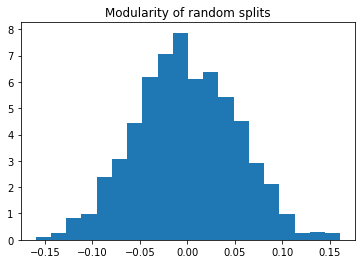

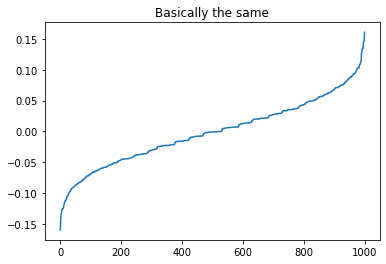

In [ ]:
plt.hist(moduls, bins = 20, density=True)
plt.title('Modularity of random splits')
plt.show()
plt.plot(np.arange(len(moduls)) , sorted(moduls))
plt.title('Basically the same')
plt.show()

### Comment on the figure. Is the club split a good partitioning? Why do you think I asked you to compare with the configuration model? What is the reason why we preserved the nodes degree?

The split of the clubs seems to be a good partitioning in regards to creating the communities, the 'null hypothesis'  here, is that the partitioning on clubs is as good as random, and therefore, there would be no significant difference in the modularity of the club partitioning vs the random partitioning. This is also what modularity actually measures: The difference between actual partition interactions, and what we would expect, given that it is a random graph.

This is also most likely why we were asked to compare to the configuration model: if the edges were random, whatever structure there is to the karate club split would be lost in the randomization process. If there is no structure in the karate data in the first place, we'd expect the modularity to not change, to remain around 0, but if there is inherent structure, it would most likely be lower, which is also what we see.

The reason for keeping all nodes' degrees is first of all the calculations for modularity: They don't really work the same way if we change the total degree of the graph. At the same time, the calculations actually calculate how much of a probable communities' edges are connected within the community, vs how much is simply random edges, changing the degree, would completely undermine this. 

In [44]:
from community import community_louvain

best_louvain_part = community_louvain.best_partition(karate_data_color)
best_louvain_part = [[node for node, cl in best_louvain_part.items() if cl == club] for club in list(set(best_louvain_part.values()))]
clubs = nx.get_node_attributes(karate_data_color, 'club')
part = [[node for node, cl in clubs.items() if cl == club] for club in ['Mr. Hi', 'Officer']]

best_karate_modularity = modularity(karate_data_color, best_louvain_part)
karate_modularity = modularity(karate_data_color, part)

print(f"Best karate {best_karate_modularity}, actual karate {karate_modularity}")

Best karate 0.41510519395134776, actual karate 0.3582347140039447


### Use the Python Louvain-algorithm implementation to find communities in this graph. Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the club split? What does this comparison reveal?

This modularity is higher than the actual modularity, which might imply that there are 'hidden' communities actually in the karate data that are not expressed only by their club. This is also revealed by the fact that the algorithm clearly found 4 different communities, rather than just 2

_Exercise: Community detection on the GME network._
> * Consider the GME network you built in [Week 4](https://github.com/lalessan/comsocsci2022/blob/main/lectures/Week4.ipynb), part 2.
> * Use [the Python Louvain-algorithm implementation](https://anaconda.org/auto/python-louvain) to find communities. How many communities do you find? What are their sizes? Report the value of modularity found by the algorithm. Is the modularity significantly different than 0? 
> * Visualize the network, using netwulf (see Week 4). This time assign each node a different color based on their _community_. Describe the structure you observe.

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
from netwulf import visualize
import netwulf as wulf
karate_data = nx.karate_club_graph()
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import json
from networkx.readwrite import json_graph

def read_json_file(filename):
    with open(filename) as f:
        js_graph = json.load(f)
    return json_graph.node_link_graph(js_graph)

In [60]:
G = read_json_file(os.getcwd() + '/reddit_network.json')

best_louvain_part = community_louvain.best_partition(karate_data_color)
best_louvain_part = [[node for node, cl in best_louvain_part.items() if cl == club]
                     for club in list(set(best_louvain_part.values()))]

modularity_GME = modularity(G, best_louvain_part)
print(modularity_GME)
# Looks pretty random to me
# Yeah its 23:46, I don't really think I can make the rest

-0.0004912062546272303
